# Imports

In [32]:
# Standard Libraries
import os
import io
import math
import time
import random
import tempfile
import warnings
from multiprocessing import Manager
from typing import Optional

# Third-party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import SimpleITK as sitk
import torch
import torch.nn as nn
import torchio as tio
from torch.utils.data import DataLoader, Dataset, random_split
from torch.cuda.amp import GradScaler, autocast

# MONAI Libraries
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.transforms import (
    AddChanneld, 
    CenterSpatialCropd, 
    Compose, 
    Lambdad, 
    LoadImaged, 
    Resized, 
    ScaleIntensityd
)
from monai.utils import set_determinism

# Custom Libraries
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
from dataloader import Train ,Eval 

# Configuration
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")
warnings.filterwarnings('ignore')


JUPYTER_ALLOW_INSECURE_WRITES=True

# Set seeds and configs

In [33]:
# Initialize Configuration
config = {
    'batch_size': 4,
    'imgDimResize': (160, 192, 160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True,
    'perc_low': 1,
    'perc_high': 99,
    'rescaleFactor': 2,
    'base_path': '/scratch1/akrami/Latest_Data/Data',
}

# Seed and Device Configuration
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CUDA and CUDNN Configuration
# Uncomment the following line to specify CUDA_VISIBLE_DEVICES
# os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,5,6'
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# SimpleITK Configuration
# Set the default number of threads and global behavior for SimpleITK
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")



True

# Load the data

In [53]:

csvpath_trains=['./combined.csv']
pathBase = '/scratch1/akrami/Data_train'
csvpath_val = '/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/IXI_val_fold0.csv'
csvpath_test = '/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/Brats21_sub_test.csv'
var_csv = {}
states = ['train','val','test']

df_list = []

# Loop through each CSV file path and read it into a DataFrame
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)

# dfffff=  pd.concat(df_list, ignore_index=True)
# dfffff.to_csv("./combined.csv", index=False)
var_csv['train'] =pd.concat(df_list, ignore_index=True)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['norm_path'] = pathBase  + var_csv[state]['norm_path']
    var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    if state != 'test':
        var_csv[state]['seg_path'] = None
    else:
        var_csv[state]['seg_path'] = pathBase  + var_csv[state]['seg_path']

    # if cfg.mode == 't2': 
    #     var_csv[state] =var_csv[state][var_csv[state].img_name.isin(keep_t2['0'].str.replace('t2','t1'))]
    #     var_csv[state]['img_path'] = var_csv[state]['img_path'].str.replace('t1','t2')
    
    
data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval(var_csv['test'],config)



# #data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=8)


# Load the model

In [35]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 128, 128],
    attention_levels=[False, False, False,True],
    num_head_channels=[0, 0, 0,32],
    num_res_blocks=2,
)
model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

Using 2 GPUs!


In [36]:
# specify your model filename
#model_filename = '/scratch1/akrami/models/3Ddiffusion/half/model_epoch984.pt'
model_filename ='./model_epoch424.pt'
# load state_dict into the model
model.load_state_dict(torch.load(model_filename))

# if you need to set the model in evaluation mode
model.eval()

DataParallel(
  (module): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
       

## Denoise test samples

In [48]:
def denoise(image_array,sample_time,scheduler,inferer,model):
    noise =torch.randn_like(image_array)
    noisy_img = scheduler.add_noise(original_samples=image_array, noise=noise, timesteps=torch.tensor(sample_time))
    noised_img = noisy_img.to(device)

    scheduler.set_timesteps(num_inference_steps=600)
    with autocast(enabled=True):
        denoised_sample = inferer.sample(input_noise=noised_img, diffusion_model=model, scheduler=scheduler)
    return denoised_sample
    

In [54]:
sub_test = next(iter(train_loader))
print(sub_test.keys())
print(sub_test['age'])
print(sub_test['vol']['data'].size())
image_array = sub_test['vol']['data']
middle_slice_idx = image_array.size(-1) // 2


dict_keys(['vol', 'peak', 'age', 'ID', 'path', 'mask'])
tensor([50, 50, 50, 50])
torch.Size([4, 1, 80, 96, 80])


In [39]:
image = torch.randn_like(image_array)[0:1,:,:,:]
image = image.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
with autocast(enabled=True):
    image = inferer.sample(input_noise=image, diffusion_model=model, scheduler=scheduler)

100%|██████████| 1000/1000 [01:08<00:00, 14.68it/s]


In [40]:
# image = torch.randn_like(image_array)[:,:,:,:]
# image = image.to(device)
# scheduler.set_timesteps(num_inference_steps=1000)
# with autocast(enabled=True):
#     image = inferer.sample_batch(input_noise=image, diffusion_model=model, scheduler=scheduler)


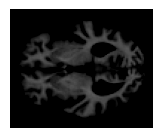

In [41]:
middle_slice_idx = image.size(-1) // 2
plt.figure(figsize=(2, 2))
plt.imshow(image[0, 0, :, :, middle_slice_idx].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

In [42]:
print(image.shape)
print(image_array.shape)

torch.Size([1, 1, 80, 96, 80])
torch.Size([4, 1, 80, 96, 80])


In [43]:
# for i, tensor_3d in enumerate(image_array):
#     # Flatten the 3D tensor to a 1D array
    
#     flattened_tensor = tensor_3d.flatten()
    
#     # Filter out values less than or equal to zero from the flattened tensor
#     non_zero_values = flattened_tensor[flattened_tensor >= .0001]
    
#     # Plot the histogram for values greater than zero
#     plt.figure()
#     plt.hist(non_zero_values, bins=20, color='green', edgecolor='black')
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')
#     plt.title(f'Histogram of Values Greater Than Zero in 3D Tensor (Sample {i+1})')
#     plt.show()




In [44]:
# sub_train = next(iter(train_loader))
# image_array = sub_train['vol']['data']
# middle_slice_idx = image_array.size(-1) // 2

In [45]:
# for i, tensor_3d in enumerate(image_array):
#     # Flatten the 3D tensor to a 1D array
    
#     flattened_tensor = tensor_3d.flatten()
    
#     # Filter out values less than or equal to zero from the flattened tensor
#     non_zero_values = flattened_tensor[flattened_tensor >= .0001]
    
#     # Plot the histogram for values greater than zero
#     plt.figure()
#     plt.hist(non_zero_values, bins=20, color='green', edgecolor='black')
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')
#     plt.title(f'Histogram of Values Greater Than Zero in 3D Tensor (Sample {i+1})')
#     plt.show()




In [55]:
sample_time = 500
recon_img = denoise(image_array[0:1,:,:,:].to(device),sample_time,scheduler,inferer,model)

100%|██████████| 600/600 [00:40<00:00, 14.74it/s]


Text(0.5, 1.0, 'Difference Image')

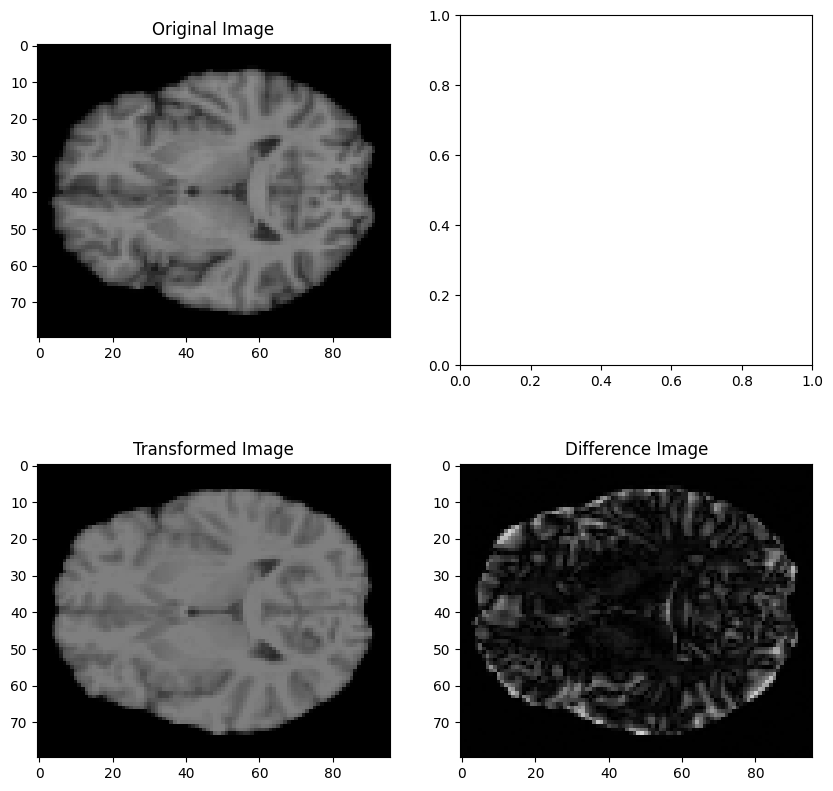

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
middle_slice_idx = int(image_array.size(-1) // 2)  
    # Original Image
axes[0, 0].imshow(image_array[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[0, 0].set_title('Original Image')

# # Segmented Image
# image_array_slice = sub_test['seg']['data'][0][0][:,:,middle_slice_idx].squeeze().cpu().numpy()
# axes[0, 1].imshow(image_array_slice, cmap='gray')
# axes[0, 1].set_title('Segmented Image')


# Transformed Image
axes[1, 0].imshow(recon_img[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
axes[1, 0].set_title('Transformed Image')
middle_slice_idx = image_array.size(-1) // 2


# Difference Image
diff_img = torch.abs(recon_img - image_array[0].to(device))
axes[1, 1].imshow(diff_img[0][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=1, cmap='gray')
axes[1, 1].set_title('Difference Image')


In [ ]:
import matplotlib.pyplot as plt
import torch

# Assume batch_size is the number of samples in your batch
batch_size = image_array.shape[0]

# Loop through each sample in the batch
for i in range(batch_size):
    # Calculate the middle slice index for this sample
    middle_slice_idx = image_array.size(-1) // 2
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    # Original Image
    axes[0, 0].imshow(image_array[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=1, cmap='gray')
    axes[0, 0].set_title('Original Image')

    # Segmented Image
    image_array_slice = sub_test['seg']['data'][i][0][:,:,middle_slice_idx].squeeze().cpu().numpy()
    axes[0, 1].imshow(image_array_slice, cmap='gray')
    axes[0, 1].set_title('Segmented Image')
    
    # Transformed Image
    axes[1, 0].imshow(recon_img[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=1, cmap='gray')
    axes[1, 0].set_title('Transformed Image')
    
    # Difference Image
    diff_img = torch.abs(recon_img - image_array.to(device))
    axes[1, 1].imshow(diff_img[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=1, cmap='gray')
    axes[1, 1].set_title('Difference Image')
    
    # Hide axis for all subplots
    for ax in axes.flatten():
        ax.axis('off')
    
    plt.suptitle(f"Sample {i+1}")
    plt.show()


In [ ]:
mask = torch.randn_like(image_array).to(device)
mask[mask<=0.5] = 0
mask[mask>0.5] = 1

In [ ]:
recon_img = val_image_inpainted*(1-mask)+val_image_inpainted*mask

In [ ]:
import tqdm as tqdm
mask = mask.to(device)
val_image_masked = image_array.to(device)*mask
val_image_inpainted = torch.randn_like(image_array).to(device)

scheduler.set_timesteps(num_inference_steps=500)
progress_bar = tqdm.tqdm(scheduler.timesteps)

num_resample_steps = 10
with torch.no_grad():
    with autocast(enabled=True):
        for t in progress_bar:
            for u in range(num_resample_steps):
                # get the known portion at t-1
                if t > 0:
                    noise =  torch.randn_like(image_array).to(device)
                    timesteps_prev = torch.Tensor((t - 1,)).to(device).long()
                    val_image_inpainted_prev_known = scheduler.add_noise(
                        original_samples=val_image_masked, noise=noise, timesteps=timesteps_prev
                    )
                else:
                    val_image_inpainted_prev_known = val_image_masked

                # perform a denoising step to get the unknown portion at t-1
                if t > 0:
                    timesteps = torch.Tensor((t,)).to(device).long()
                    model_output = model(val_image_inpainted, timesteps=timesteps)
                    val_image_inpainted_prev_unknown, _ = scheduler.step(model_output, t, val_image_inpainted)

                # combine known and unknown using the mask
                val_image_inpainted = torch.where(
                    mask == 1, val_image_inpainted_prev_known, val_image_inpainted_prev_unknown
                )

                # perform resampling
                if t > 0 and u < (num_resample_steps - 1):
                    # sample x_t from x_t-1
                    noise = torch.randn_like(image_array).to(device)
                    val_image_inpainted = (
                        torch.sqrt(1 - scheduler.betas[t - 1]) * val_image_inpainted
                        + torch.sqrt(scheduler.betas[t - 1]) * noise
                    )


                    

# plot


mask_2 =1- (mask.to(device))
val_image_masked_2 = image_array.to(device)*mask_2
val_image_inpainted_2 = torch.randn_like(image_array).to(device)

scheduler.set_timesteps(num_inference_steps=500)
progress_bar = tqdm.tqdm(scheduler.timesteps)

num_resample_steps = 4
with torch.no_grad():
    with autocast(enabled=True):
        for t in progress_bar:
            for u in range(num_resample_steps):
                # get the known portion at t-1
                if t > 0:
                    noise =  torch.randn_like(image_array).to(device)
                    timesteps_prev = torch.Tensor((t - 1,)).to(device).long()
                    val_image_inpainted_prev_known = scheduler.add_noise(
                        original_samples=val_image_masked_2, noise=noise, timesteps=timesteps_prev
                    )
                else:
                    val_image_inpainted_prev_known = val_image_masked_2

                # perform a denoising step to get the unknown portion at t-1
                if t > 0:
                    timesteps = torch.Tensor((t,)).to(device).long()
                    model_output = model(val_image_inpainted_2, timesteps=timesteps)
                    val_image_inpainted_prev_unknown, _ = scheduler.step(model_output, t, val_image_inpainted_2)

                # combine known and unknown using the mask
                val_image_inpainted_2 = torch.where(
                    mask_2 == 1, val_image_inpainted_prev_known, val_image_inpainted_prev_unknown
                )



In [ ]:
import matplotlib.pyplot as plt
import torch

# Assume batch_size is the number of samples in your batch
batch_size = image_array.shape[0]

# Loop through each sample in the batch
for i in range(batch_size):
    # Calculate the middle slice index for this sample
    middle_slice_idx = image_array.size(-1) // 2
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    # Original Image
    axes[0, 0].imshow(image_array[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=1, cmap='gray')
    axes[0, 0].set_title('Original Image')

    # Segmented Image
    image_array_slice = sub_test['seg']['data'][i][0][:,:,middle_slice_idx].squeeze().cpu().numpy()
    axes[0, 1].imshow(image_array_slice, cmap='gray')
    axes[0, 1].set_title('Segmented Image')
    
    # Transformed Image
    axes[1, 0].imshow(recon_img[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=1, cmap='gray')
    axes[1, 0].set_title('Transformed Image')
    
    # Difference Image
    diff_img = torch.abs(recon_img - image_array.to(device))
    axes[1, 1].imshow(diff_img[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=1, cmap='gray')
    axes[1, 1].set_title('Difference Image')
    
    # Hide axis for all subplots
    for ax in axes.flatten():
        ax.axis('off')
    
    plt.suptitle(f"Sample {i+1}")
    plt.show()
